In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scFates as scf
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


# Part I: Filtering Visceral Endoderm Cells

In [2]:
adata = sc.read_h5ad("/Users/ryang/Documents/Academics/Spring 2024/CSCB/Homework/HW3/adHW3_2024.h5ad")
adata.shape

(3274, 29330)

In [3]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adata, use_highly_variable=True)

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

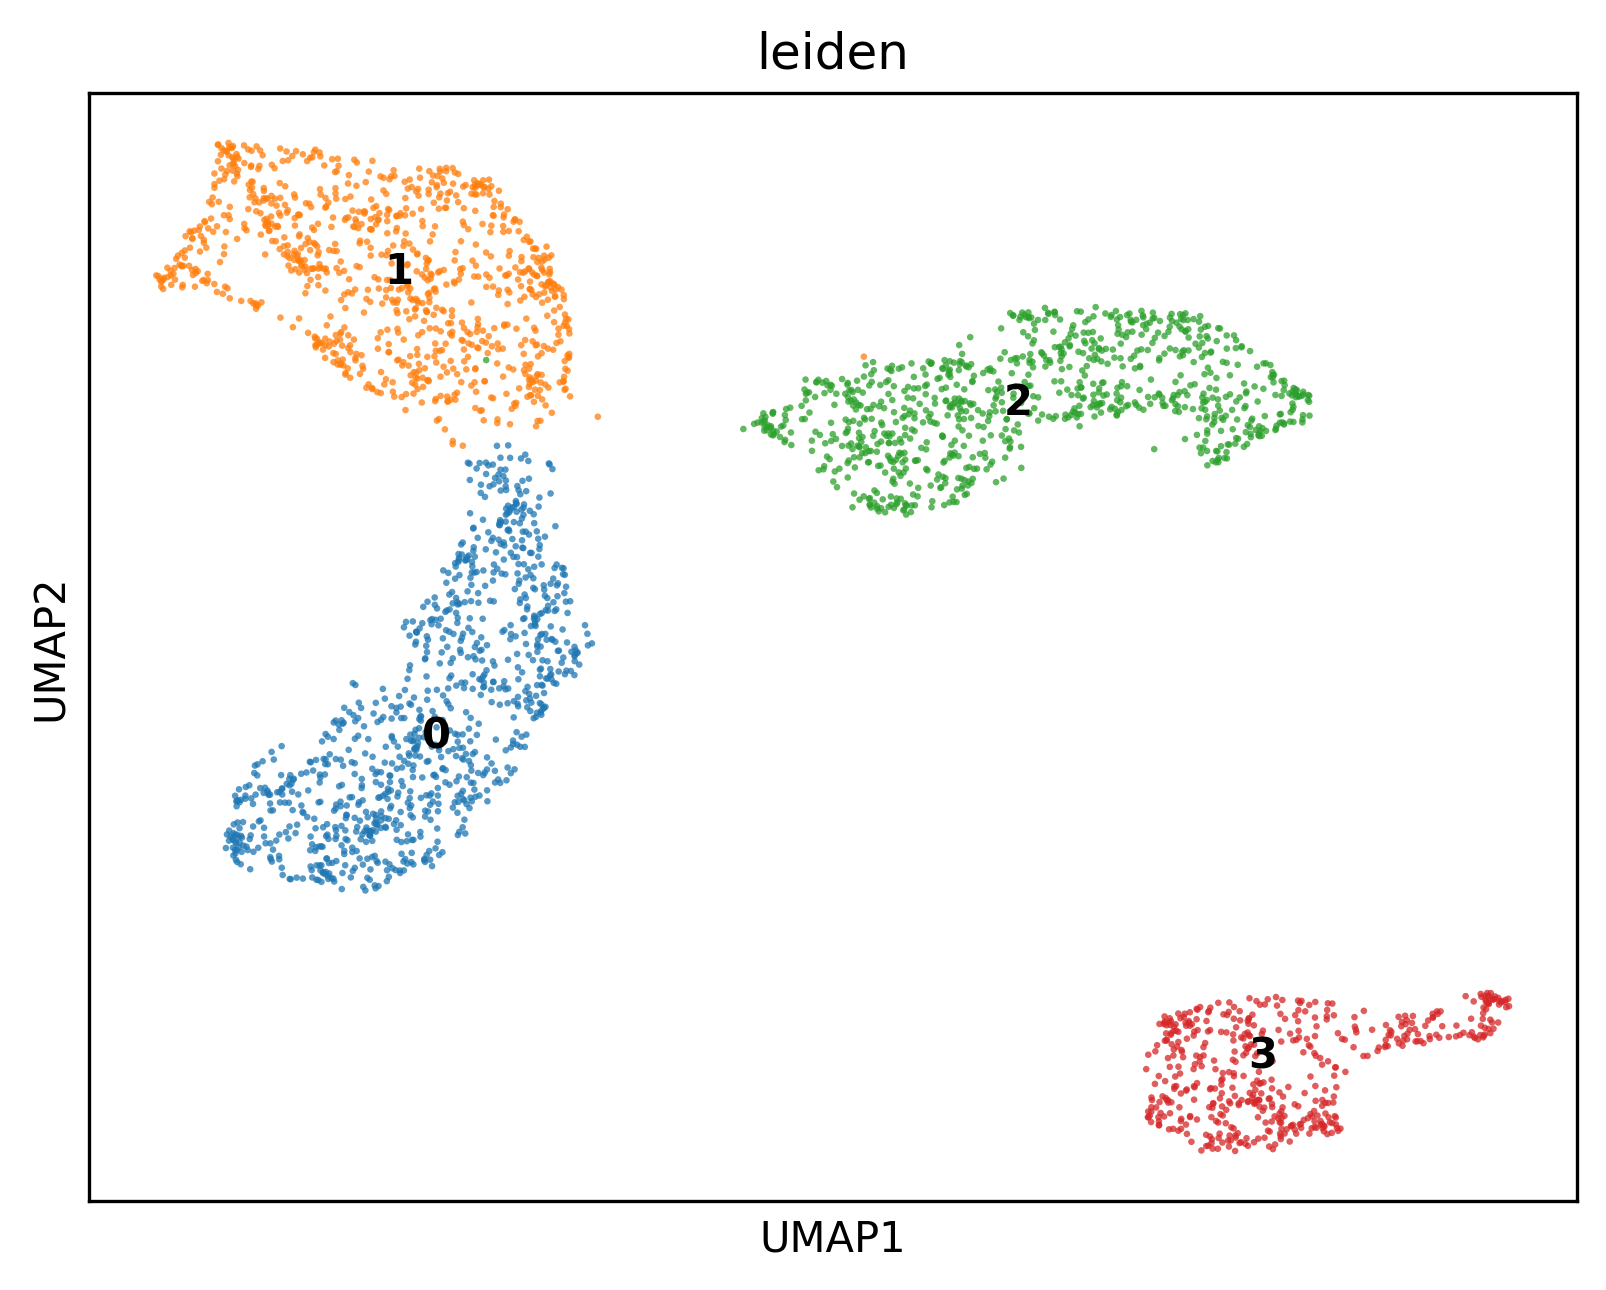

In [4]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)
sc.tl.leiden(adata,.1)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, 0.25, init_pos='paga')
sc.pl.umap(adata,color=['leiden'], alpha=.75, s=10, legend_loc='on data', show=False)

Visceral Endoderm Gene Markers Source:

Li, LC., Wang, X., Xu, ZR. et al. Single-cell patterning and axis characterization in the murine and human definitive endoderm. Cell Res 31, 326–344 (2021). https://doi.org/10.1038/s41422-020-00426-0 

In [5]:
marker_genes_dict = {
    'Epiblast': ['Utf1', 'Slc7a3', 'Pou3f1'],
    'Mesoderm': ['Mesp1', 'Fgf3', 'Snai1'],
    'Anterior primitive streak': ['Foxa2', 'Gsc', 'Sox17'],
    'Visceral endoderm': ['Rhox5', 'Trap1a', 'Spink1']
}

categories: 0, 1, 2, etc.
var_group_labels: Epiblast, Mesoderm, Anterior primitive streak, etc.


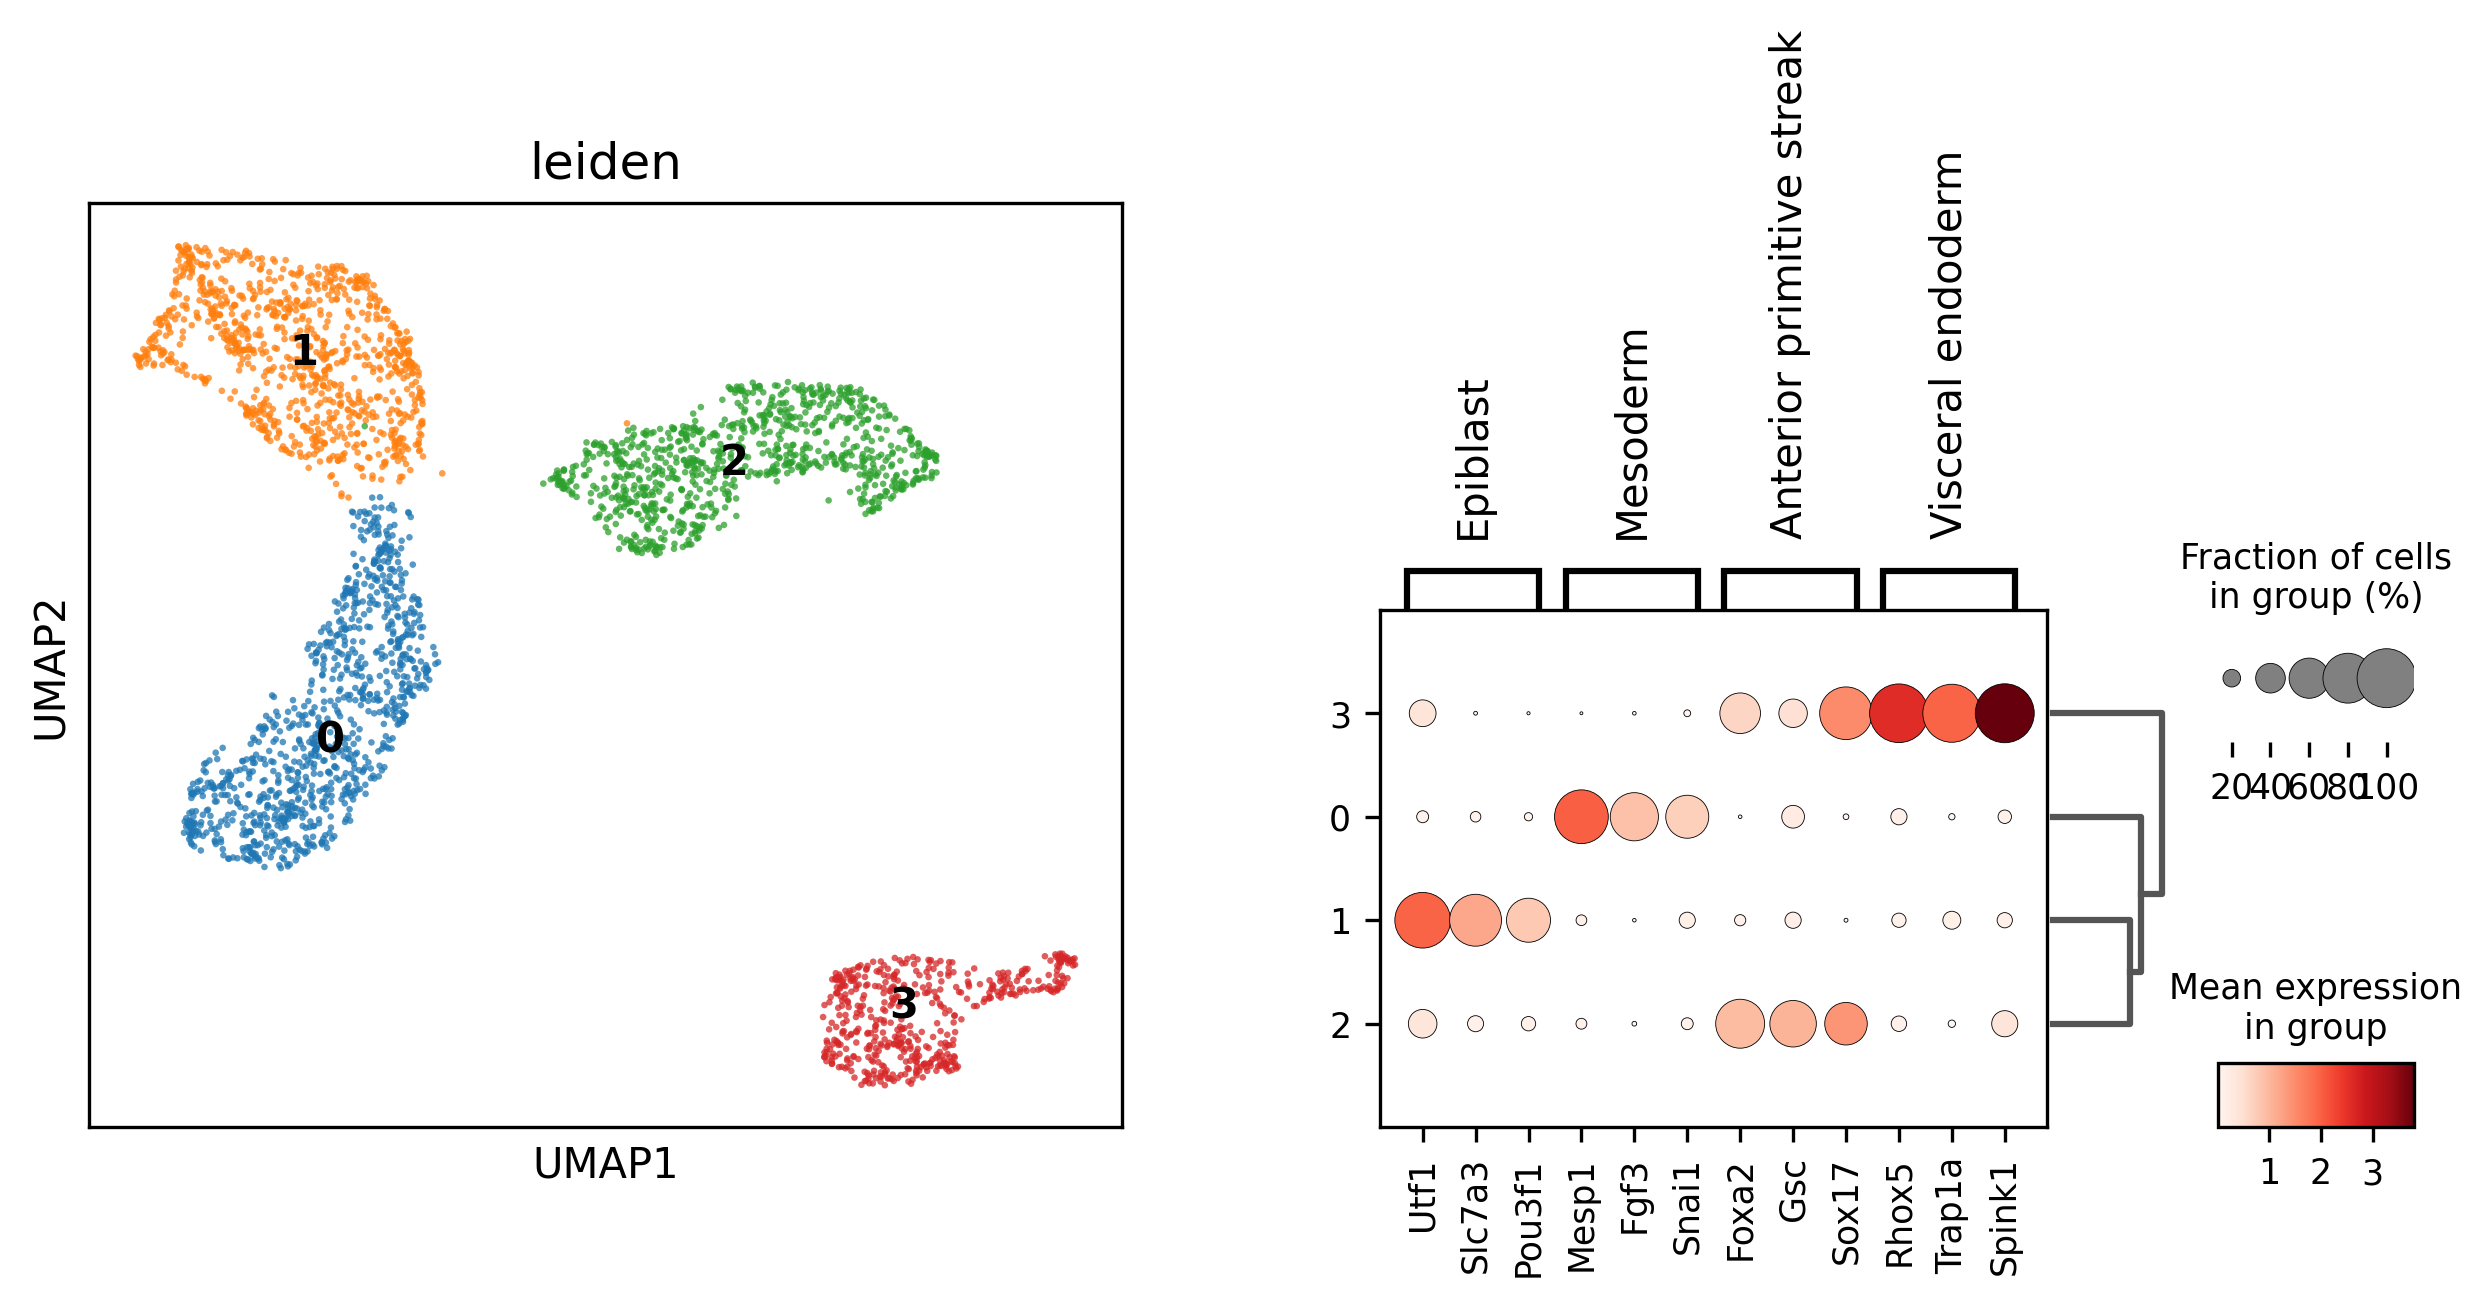

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adata,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adata, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

In [7]:
cell_dict = {
    'Epiblast': ['1'],
    'Mesoderm': ['0'],
    'Anterior primitive streak': ['2'],
    'Visceral endoderm': ['3']
}

adata.obs['cell_type_pred'] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'cell_type_pred'] = i

adata.obs['cell_type_pred'] = adata.obs['cell_type_pred'].astype("category")
adata.obs['cell_type_pred']

cell_15                         Epiblast
cell_74                         Epiblast
cell_182                        Epiblast
cell_216               Visceral endoderm
cell_219                        Epiblast
                         ...            
cell_126110            Visceral endoderm
cell_126532            Visceral endoderm
cell_129498    Anterior primitive streak
cell_129854            Visceral endoderm
cell_135701            Visceral endoderm
Name: cell_type_pred, Length: 3274, dtype: category
Categories (4, object): ['Anterior primitive streak', 'Epiblast', 'Mesoderm', 'Visceral endoderm']

In [8]:
filtered_adata = adata[adata.obs['cell_type_pred'] != 'Visceral endoderm']
filtered_adata.shape

(2778, 16004)

# Part II: Trajectory Analysis

In [41]:
ad2 = filtered_adata.copy()

In [42]:
sc.pp.highly_variable_genes(ad2, min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(ad2, use_highly_variable=True)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.5, lambda = 75, metric = euclidean
    fitting:   0%|          | 0/50 [00:00<?, ?it/s]

    fitting:  84%|████████▍ | 42/50 [00:00<00:00, 58.56it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


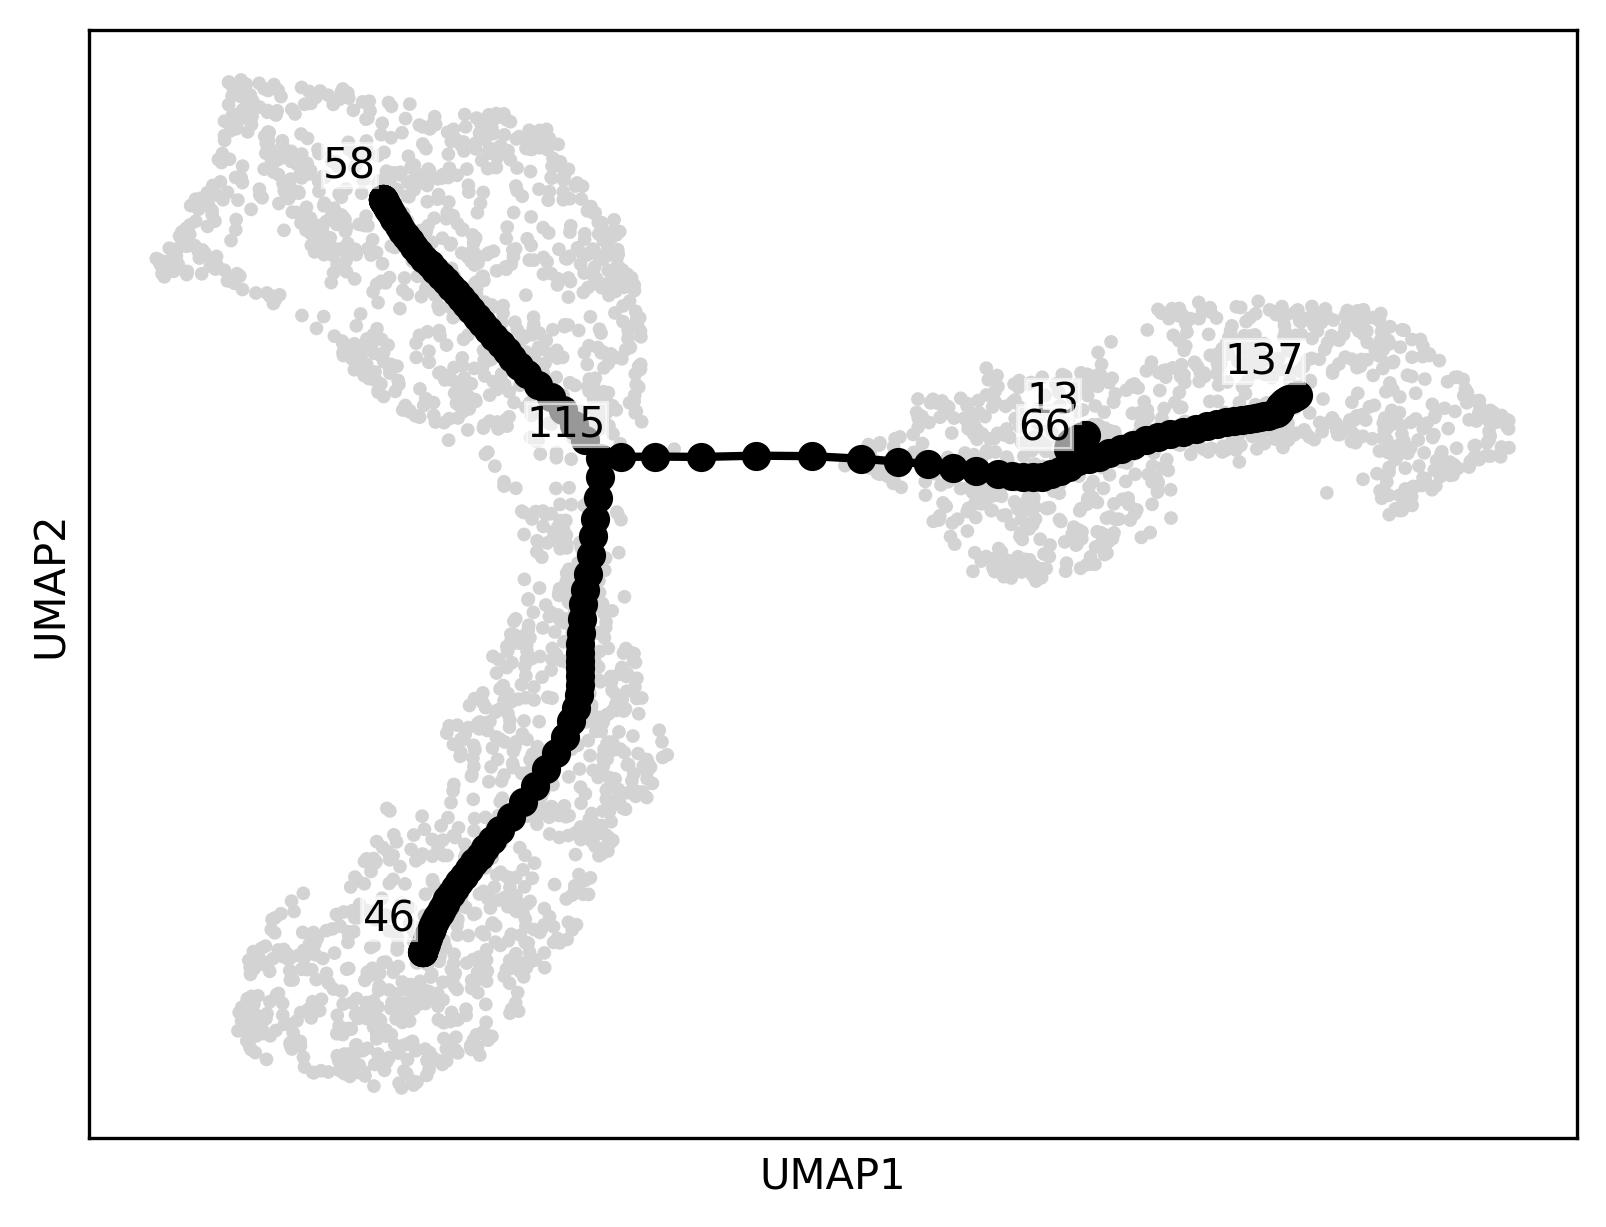

In [44]:
adT = ad2.copy()
scf.tl.tree(adT,method="ppt",Nodes=200, ppt_sigma = 0.5, ppt_lambda = 75, use_rep='X_pca', ndims_rep=2)      # Compute the tree
scf.pl.graph(adT, basis='umap')                                                                      # Plot the tree

| Milestone | Cluster |
| --------- | ------- |
|    58     | Epiblast|
|   115     | Bifurcation |
|    46     | Mesoderm |
| 66, 13, 137 | APS |

node 58 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


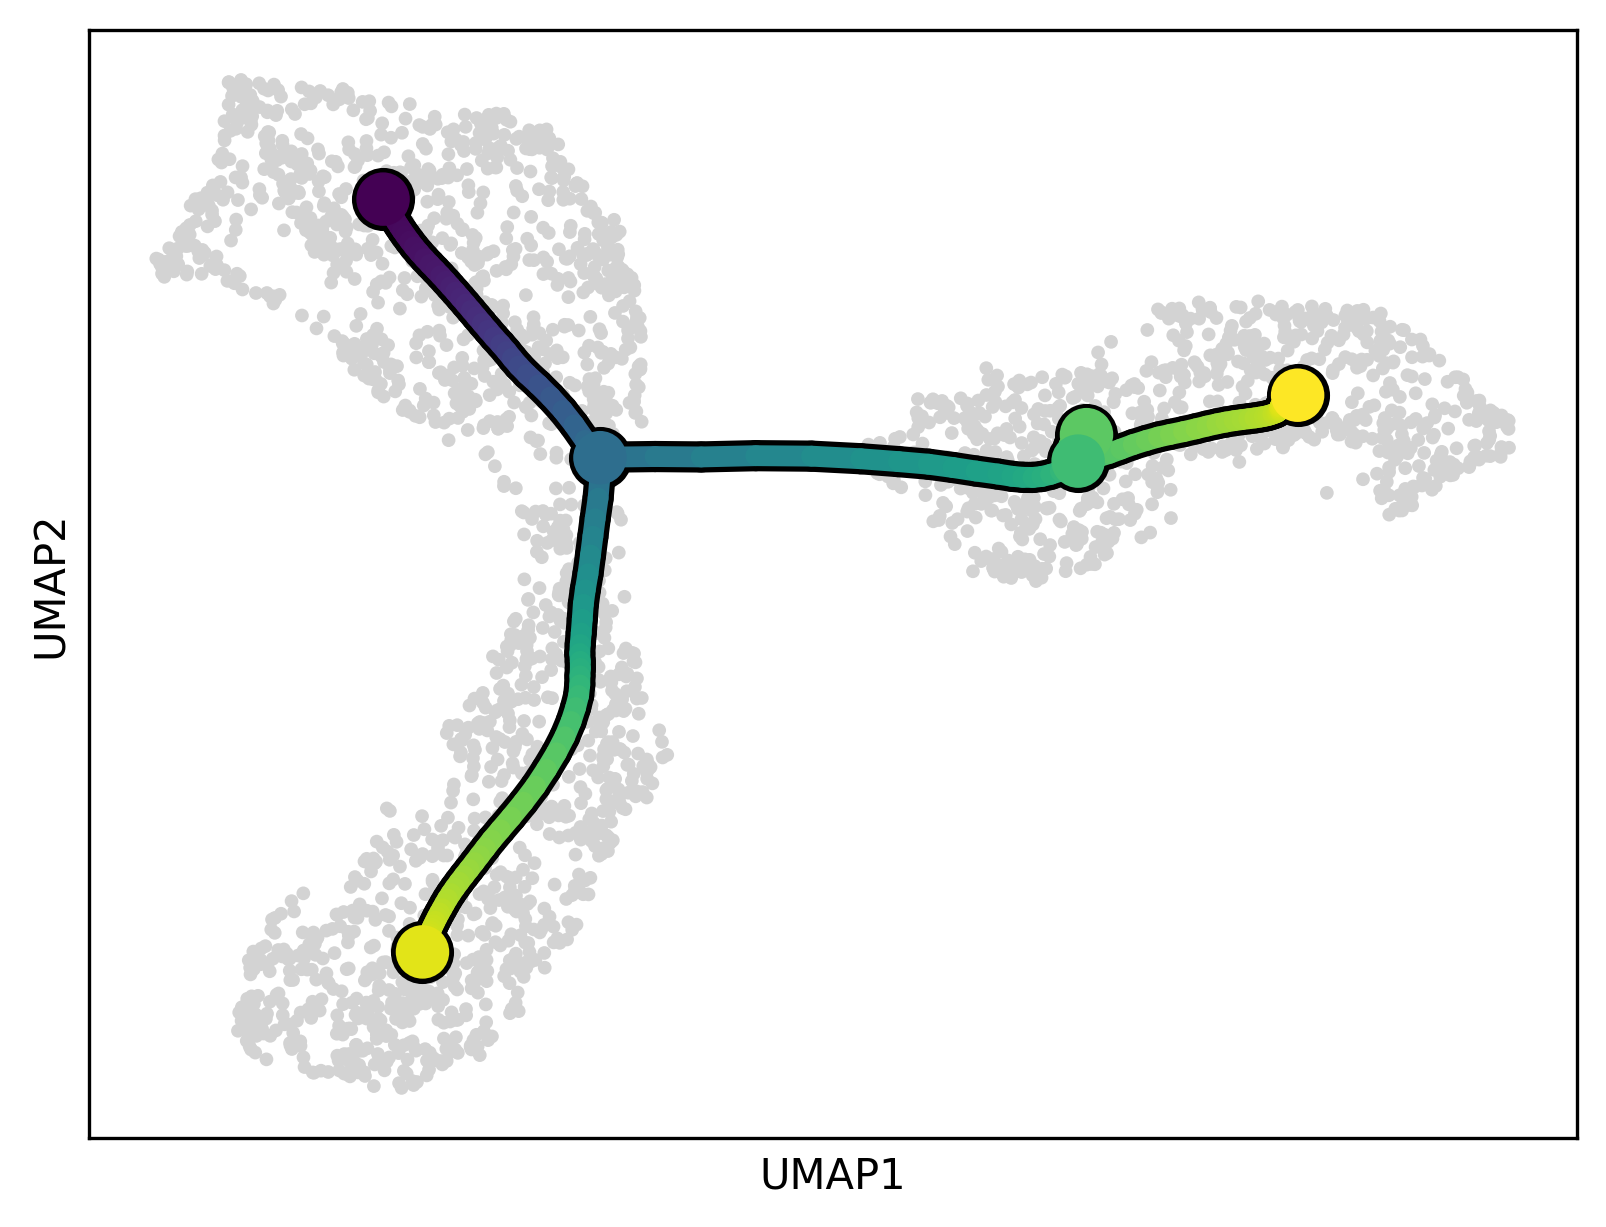

In [46]:
adTree = adT.copy()
scf.tl.root(adTree, root = 58)
scf.tl.pseudotime(adTree)
scf.pl.trajectory(adTree, basis = "umap")

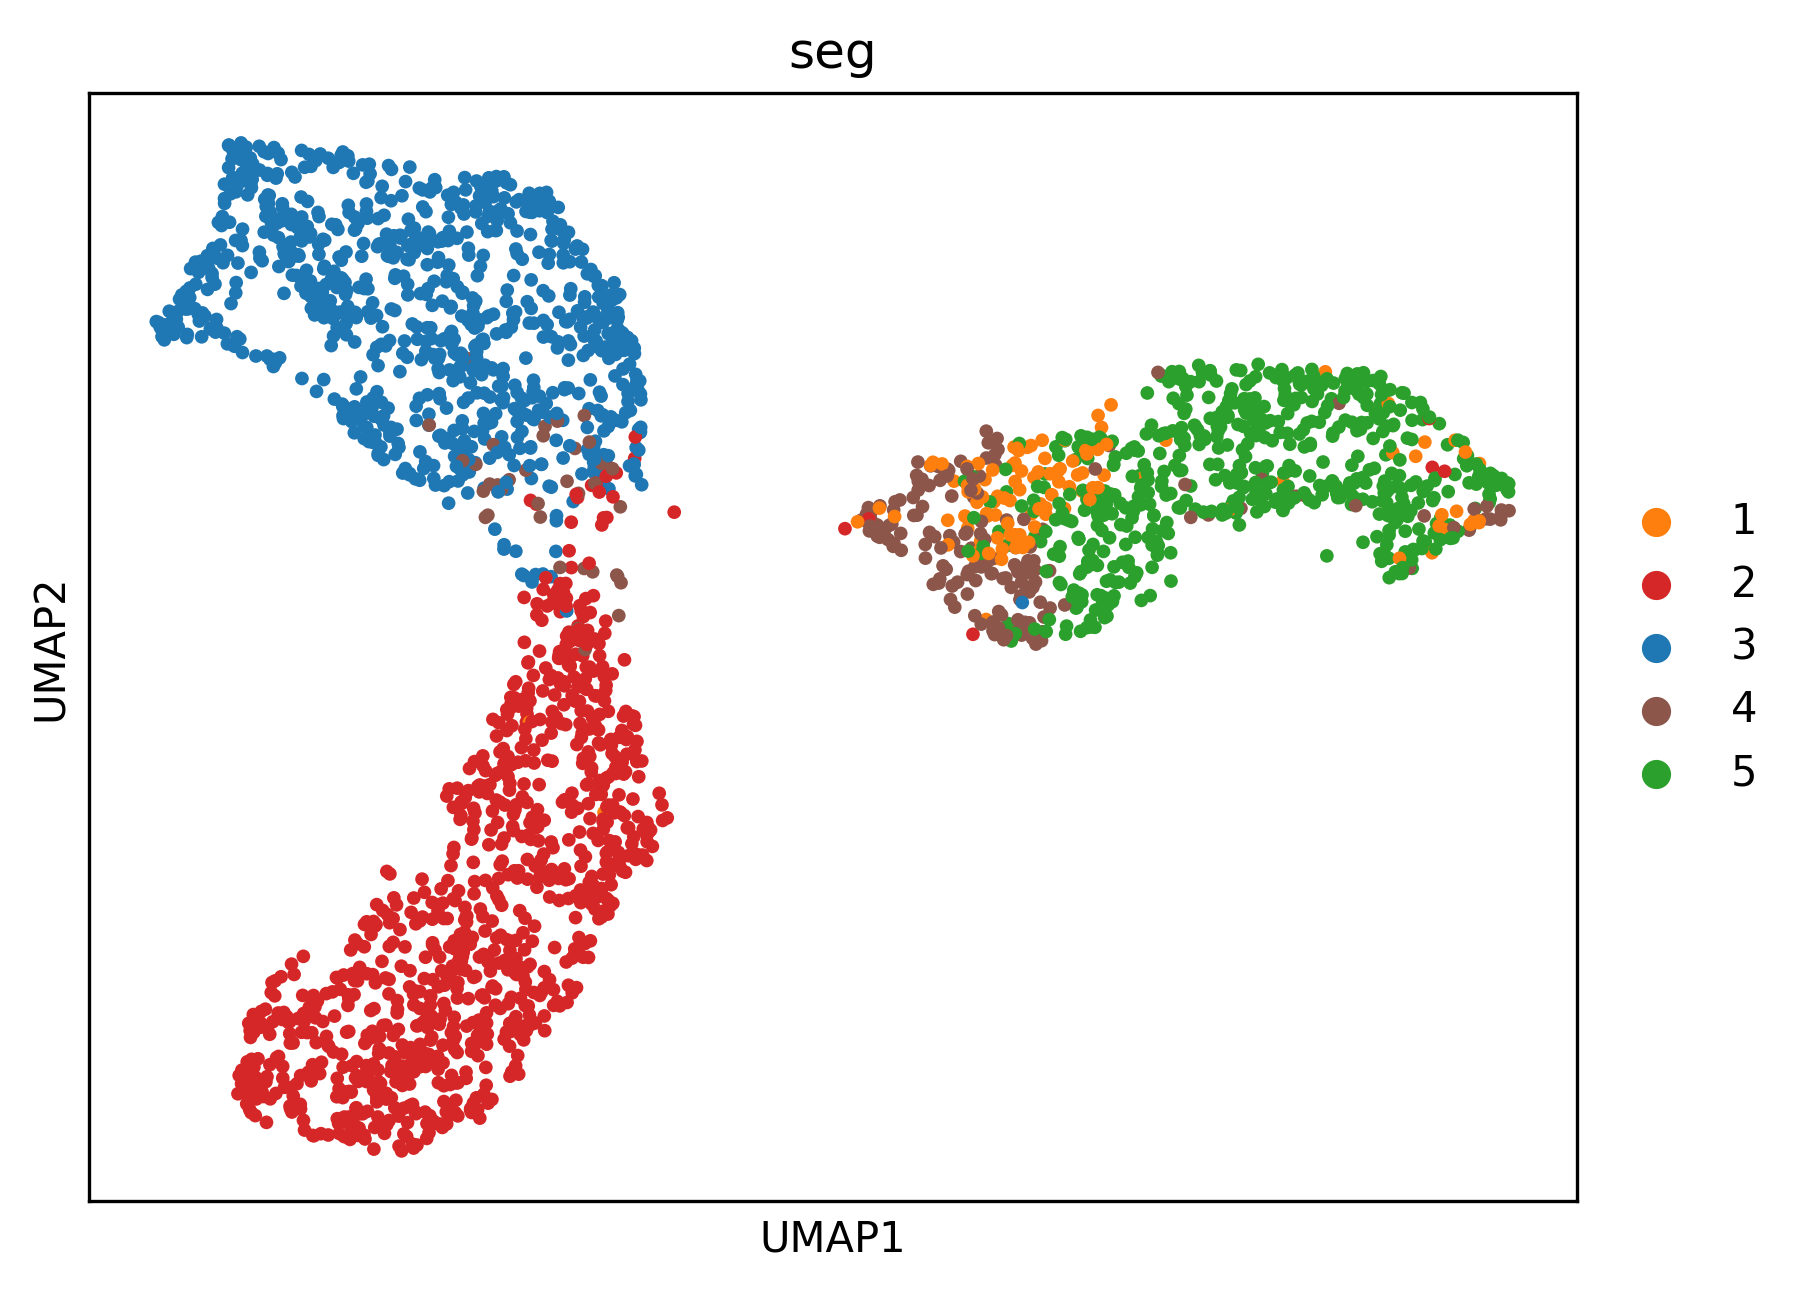

In [47]:
sc.pl.umap(adTree, color = 'seg')

Generating dendrogram of tree
    segment :   0%|          | 0/5 [00:00<?, ?it/s]

    segment : 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]
    finished (0:00:01) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


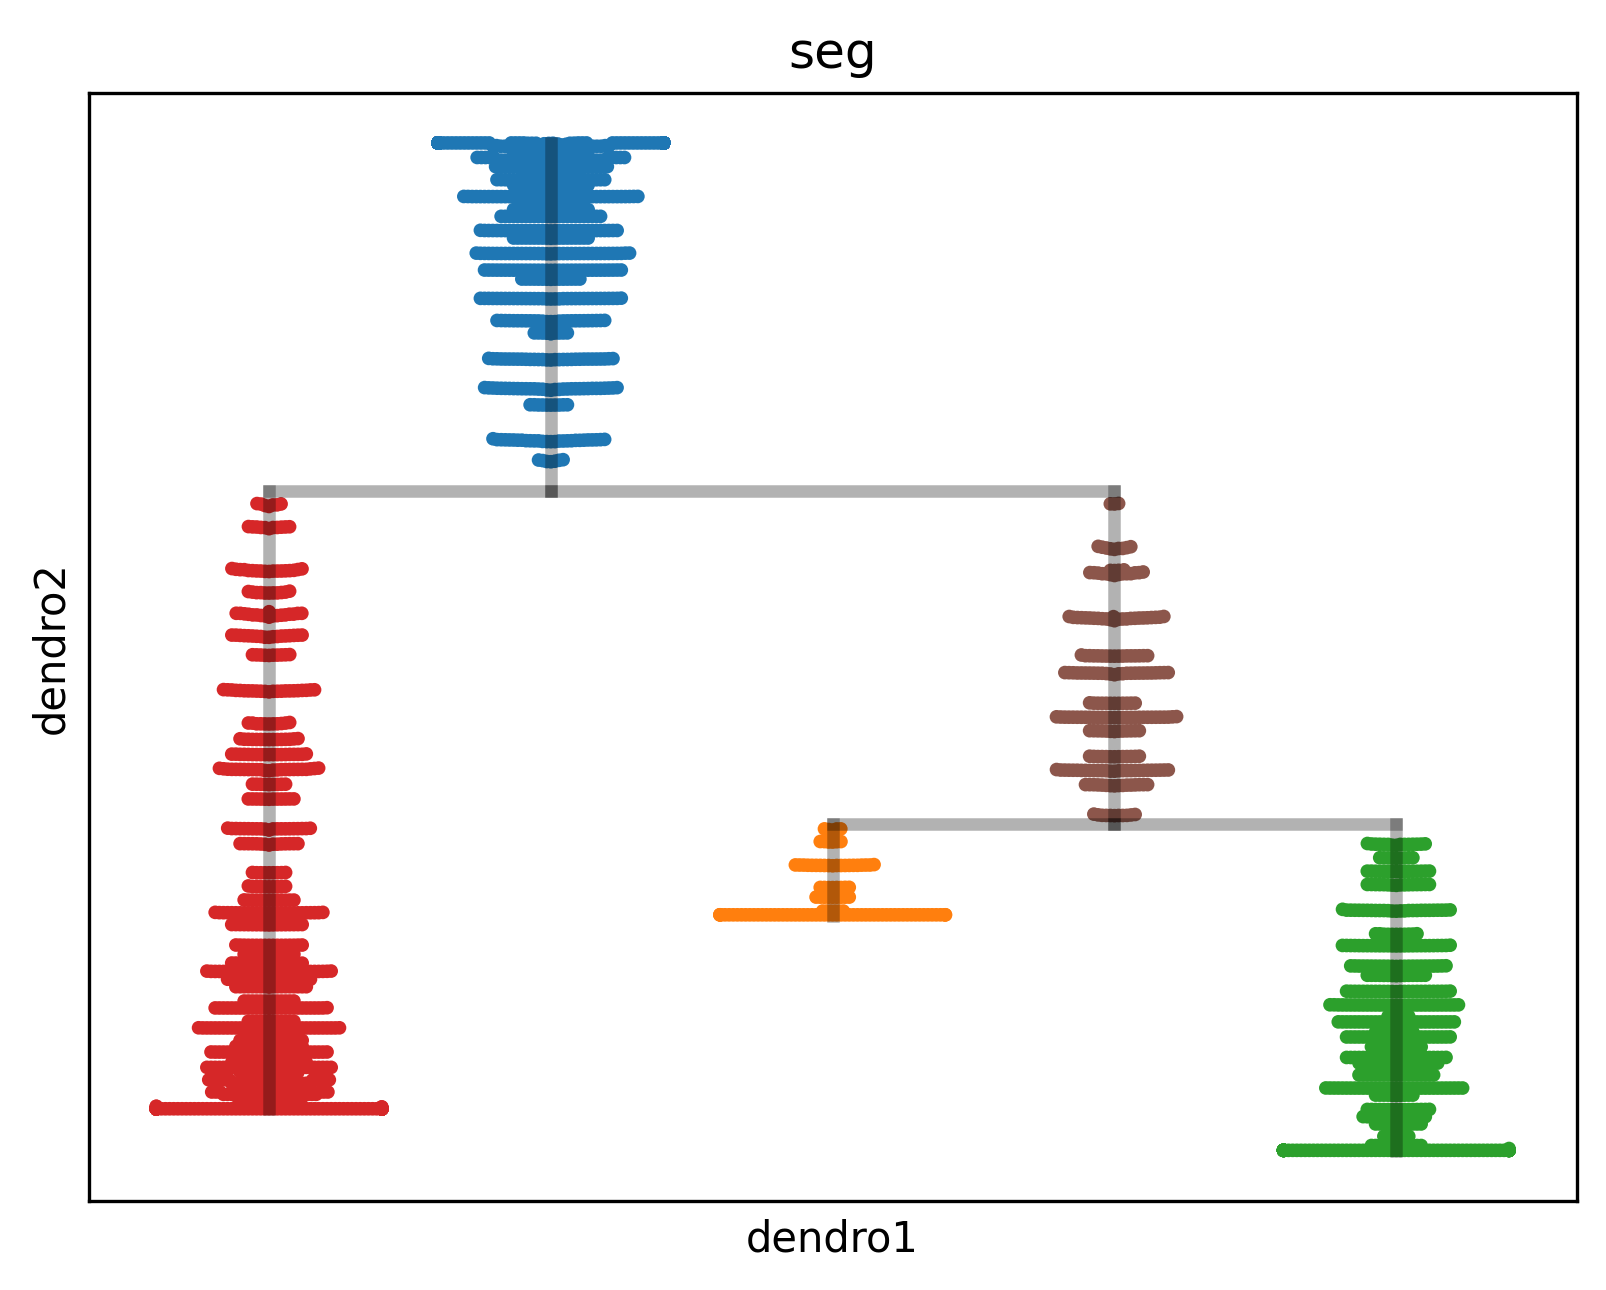

In [48]:
scf.tl.dendrogram(adTree)
scf.pl.dendrogram(adTree,color="seg",show_info=False)

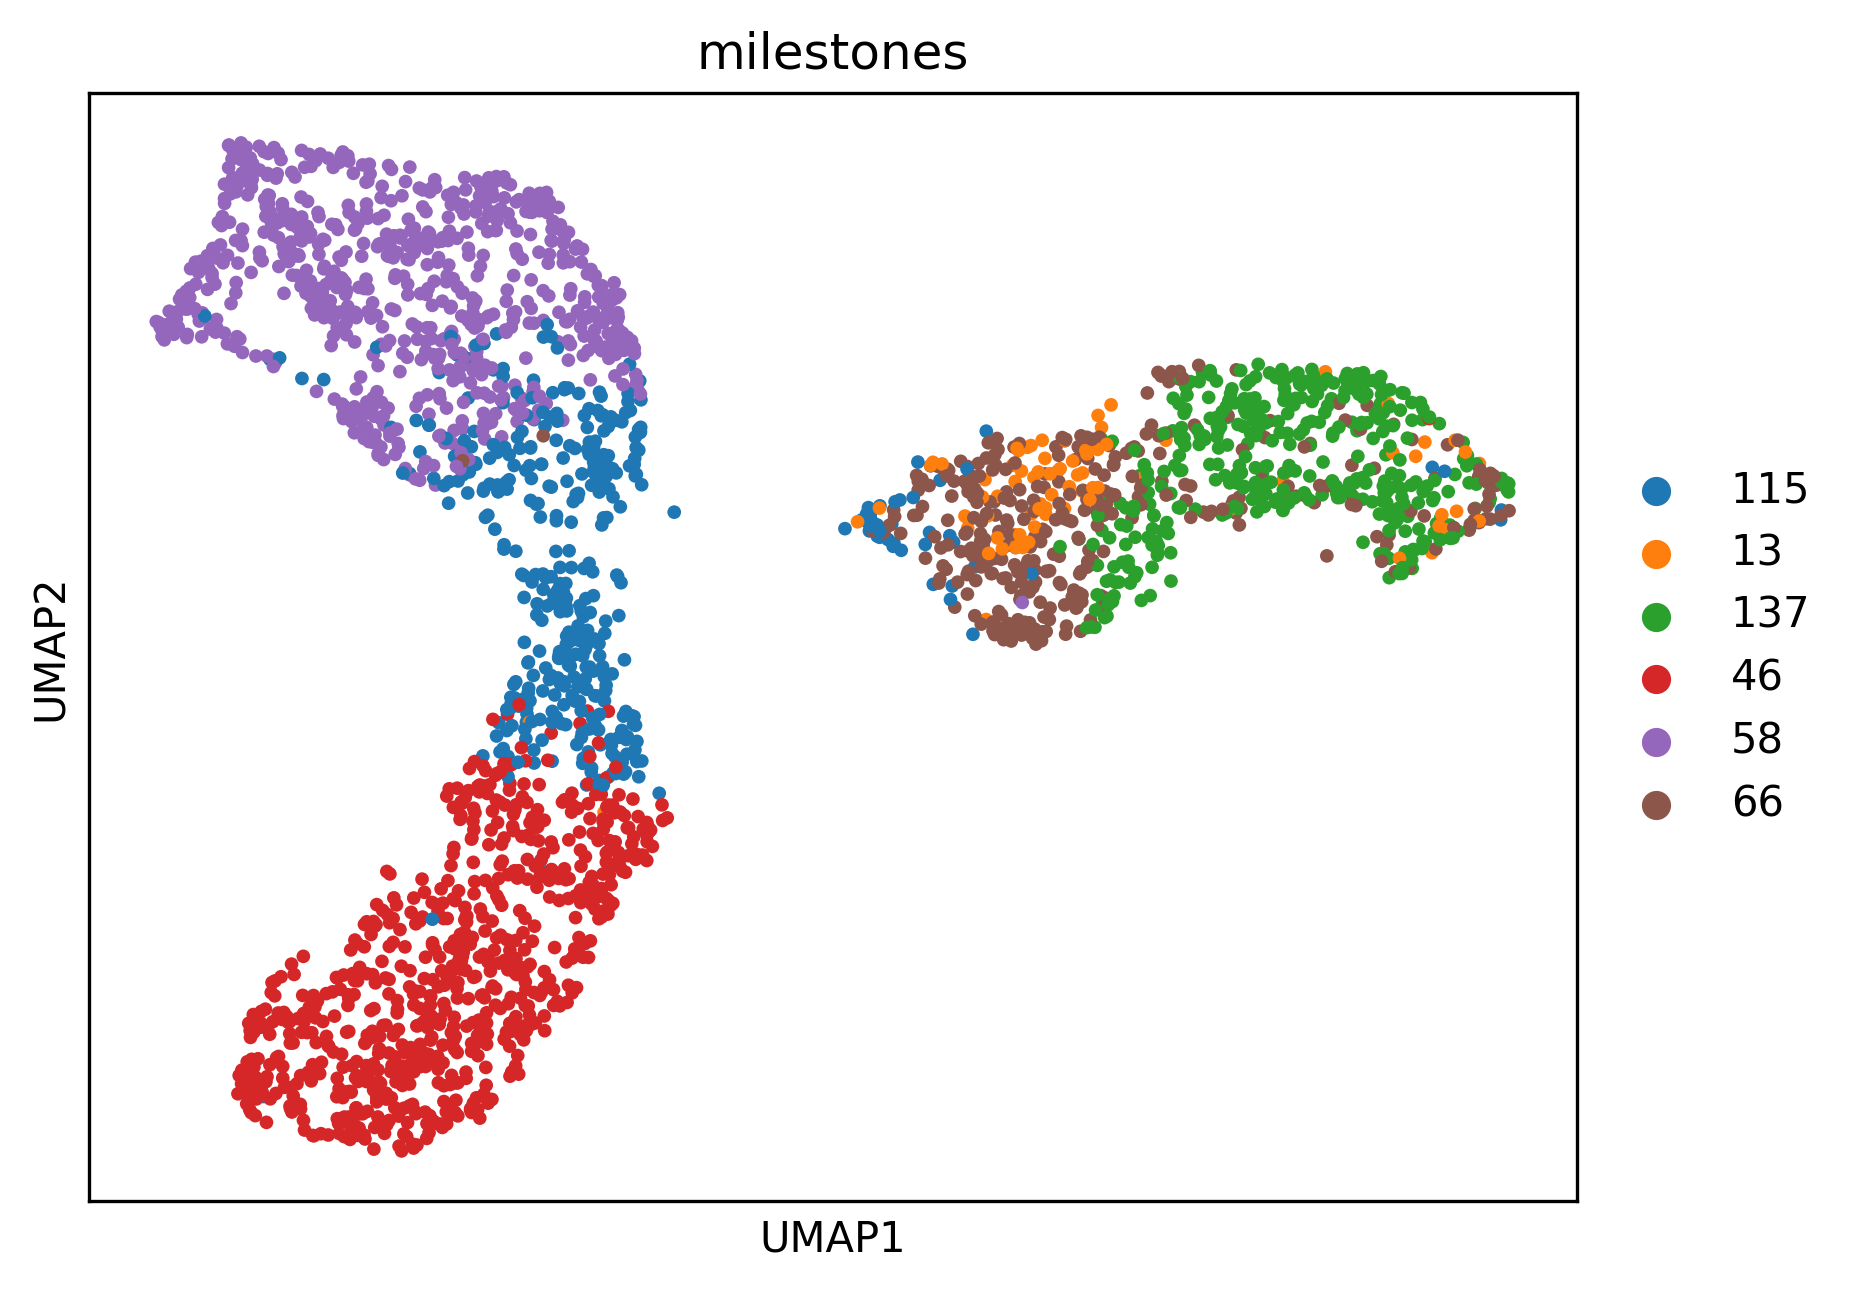

In [49]:
sc.pl.umap(adTree,color="milestones")

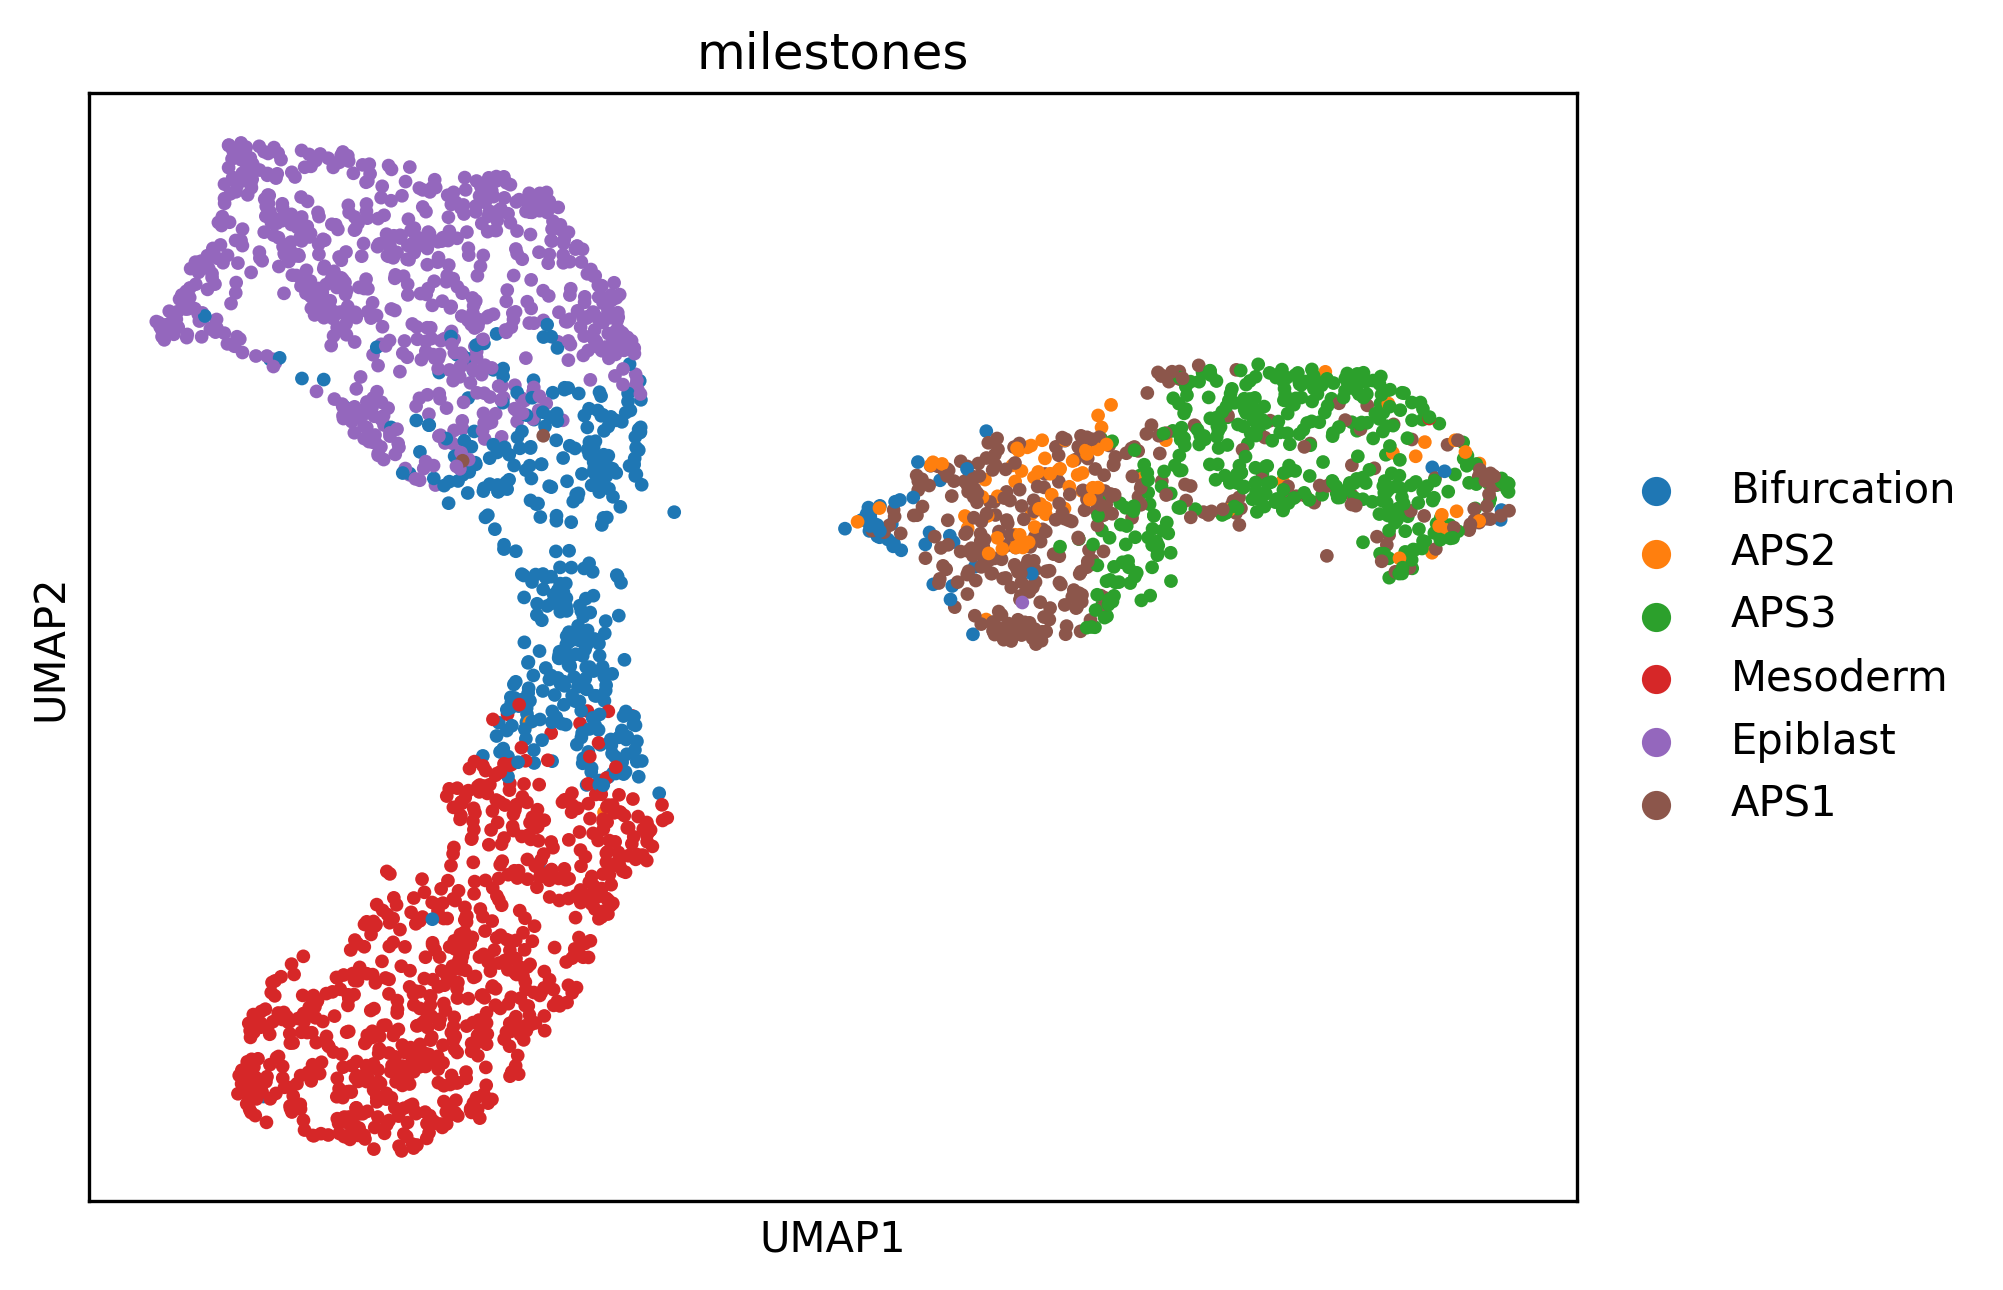

In [50]:
scf.tl.rename_milestones(adTree,["Bifurcation", "APS2", "APS3", "Mesoderm", "Epiblast", "APS1"])
sc.pl.umap(adTree,color="milestones")

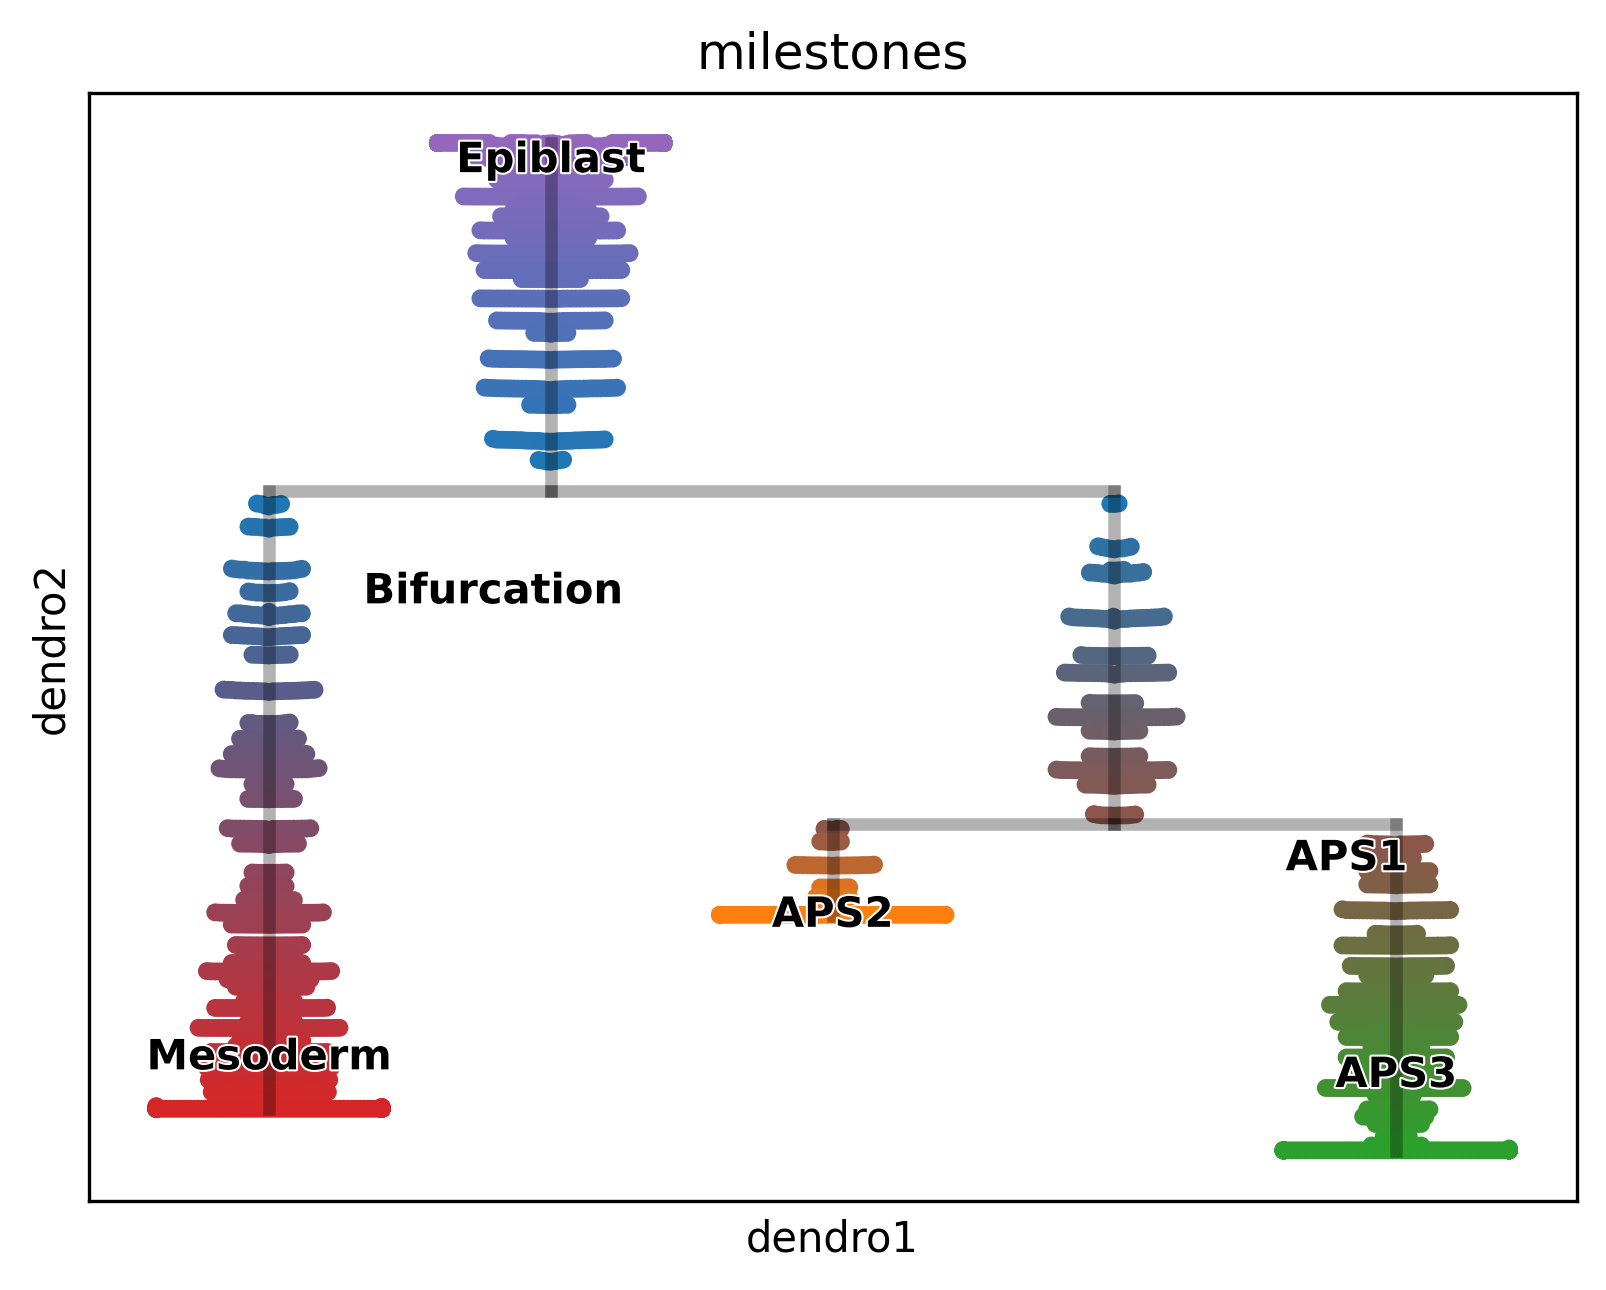

In [51]:
scf.pl.dendrogram(adTree,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True)

# Part III: Transcription Factors

In [52]:
!pip3 install rpy2

In [53]:
mouse_tf = pd.read_csv('allTFs_mm_aertslab_011924.csv', header=None, usecols=[0])
mouse_tf

0
0          Bcl6b
1        Zscan26
2           Mtf1
3           Klf9
4           Zic5
...          ...
1855  Zscan4-ps3
1856     Zscan4b
1857     Zscan4e
1858      Zswim1
1859        Zxdb

[1860 rows x 1 columns]

In [54]:
adTF = adTree.copy()
adTF = adTF[:, adTF.var_names.isin(mouse_tf[0])]
scf.tl.test_association(adTF, reapply_filters=True)
scf.tl.fit(adTF)

test features for association with the trajectory
    single mapping : 100%|██████████| 1549/1549 [01:33<00:00, 16.65it/s]
    found 24 significant features (0:01:33) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.
fit features associated with the trajectory
    single mapping : 100%|██████████| 24/24 [00:05<00:00,  4.14it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:05) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [60]:
scf.tl.cluster(adTF, n_pcs=20)

Clustering features using fitted layer
    finished (0:00:00) --> added 
    .var['clusters'] identified modules.


In [61]:
adTF.var.clusters.unique()

['2', '1', '3', '0']
Categories (4, object): ['0', '1', '2', '3']

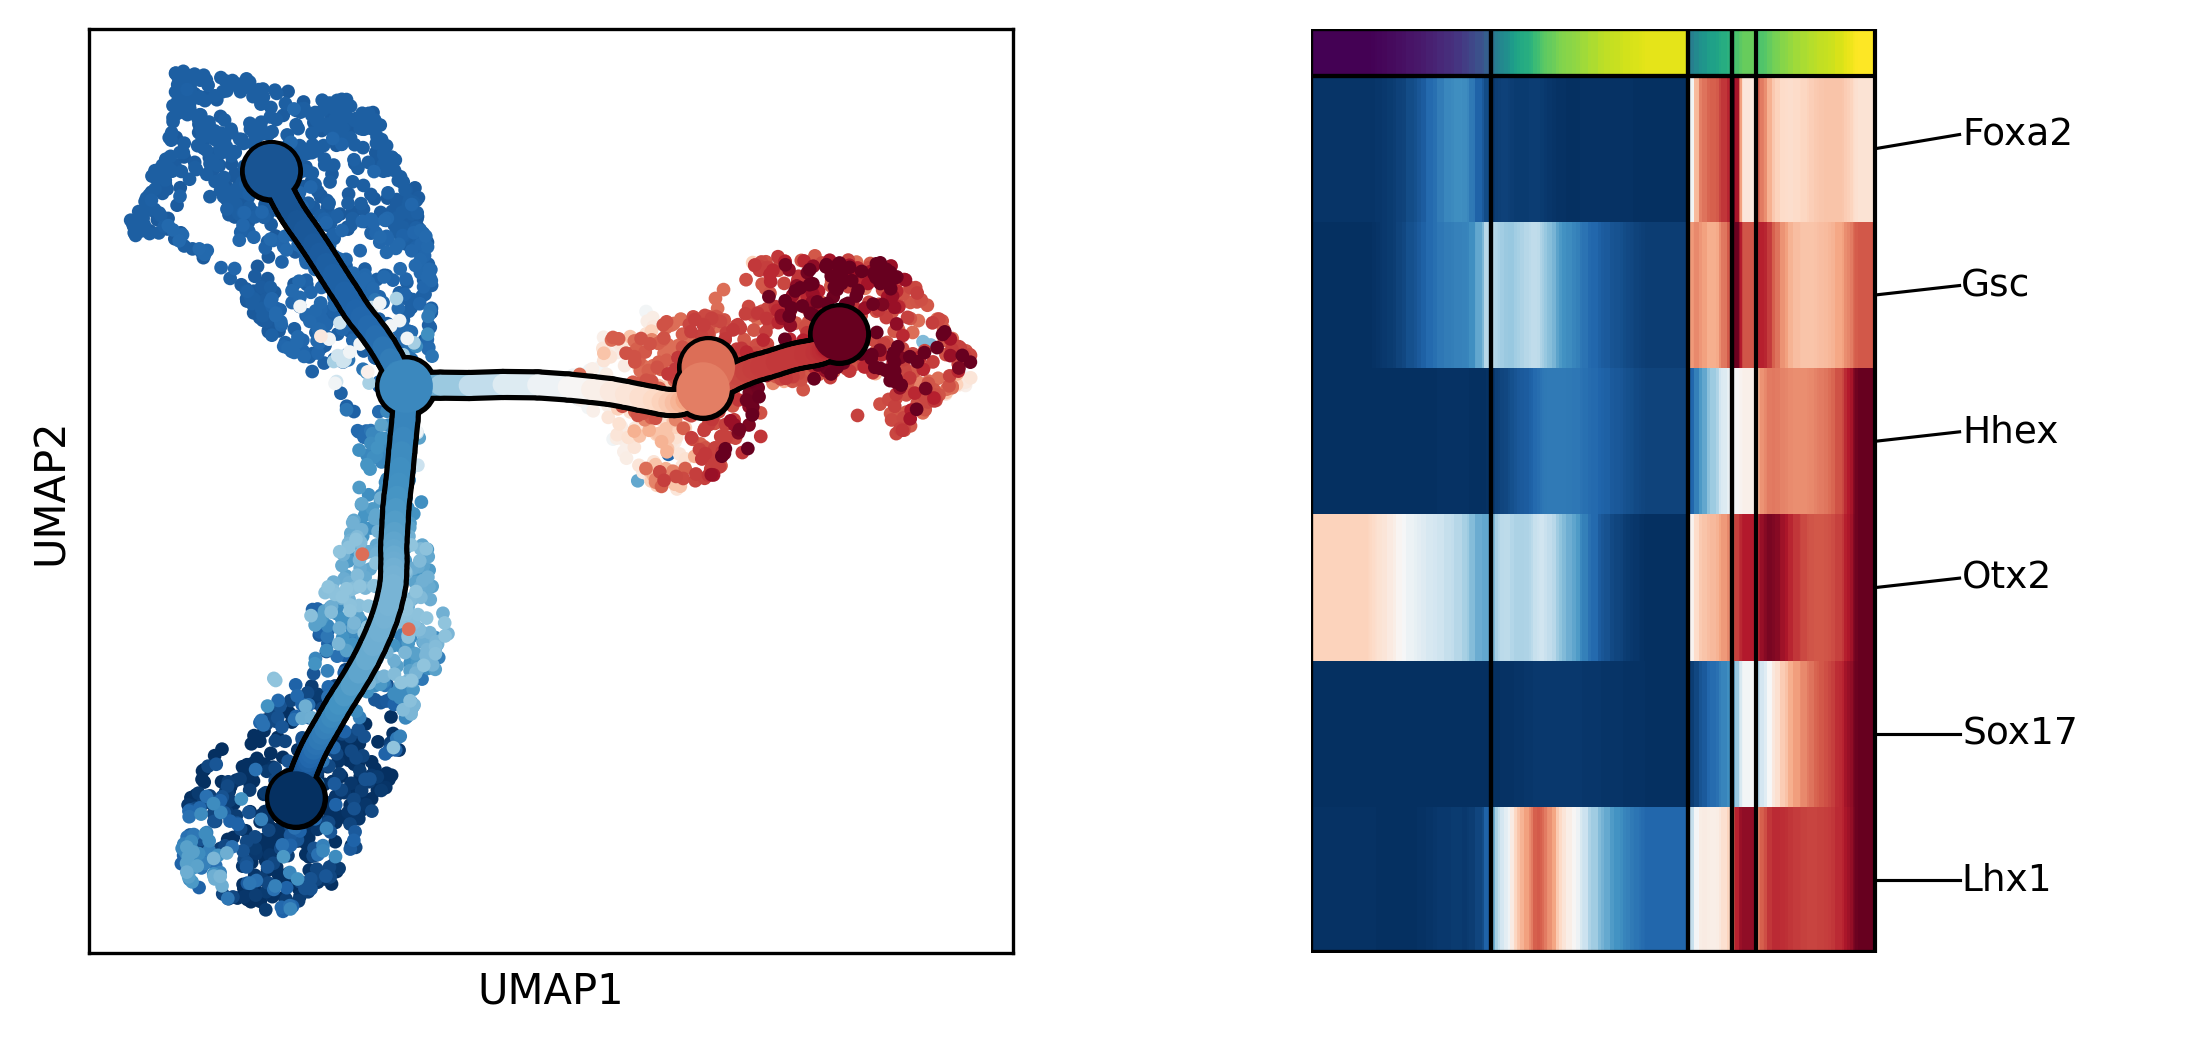

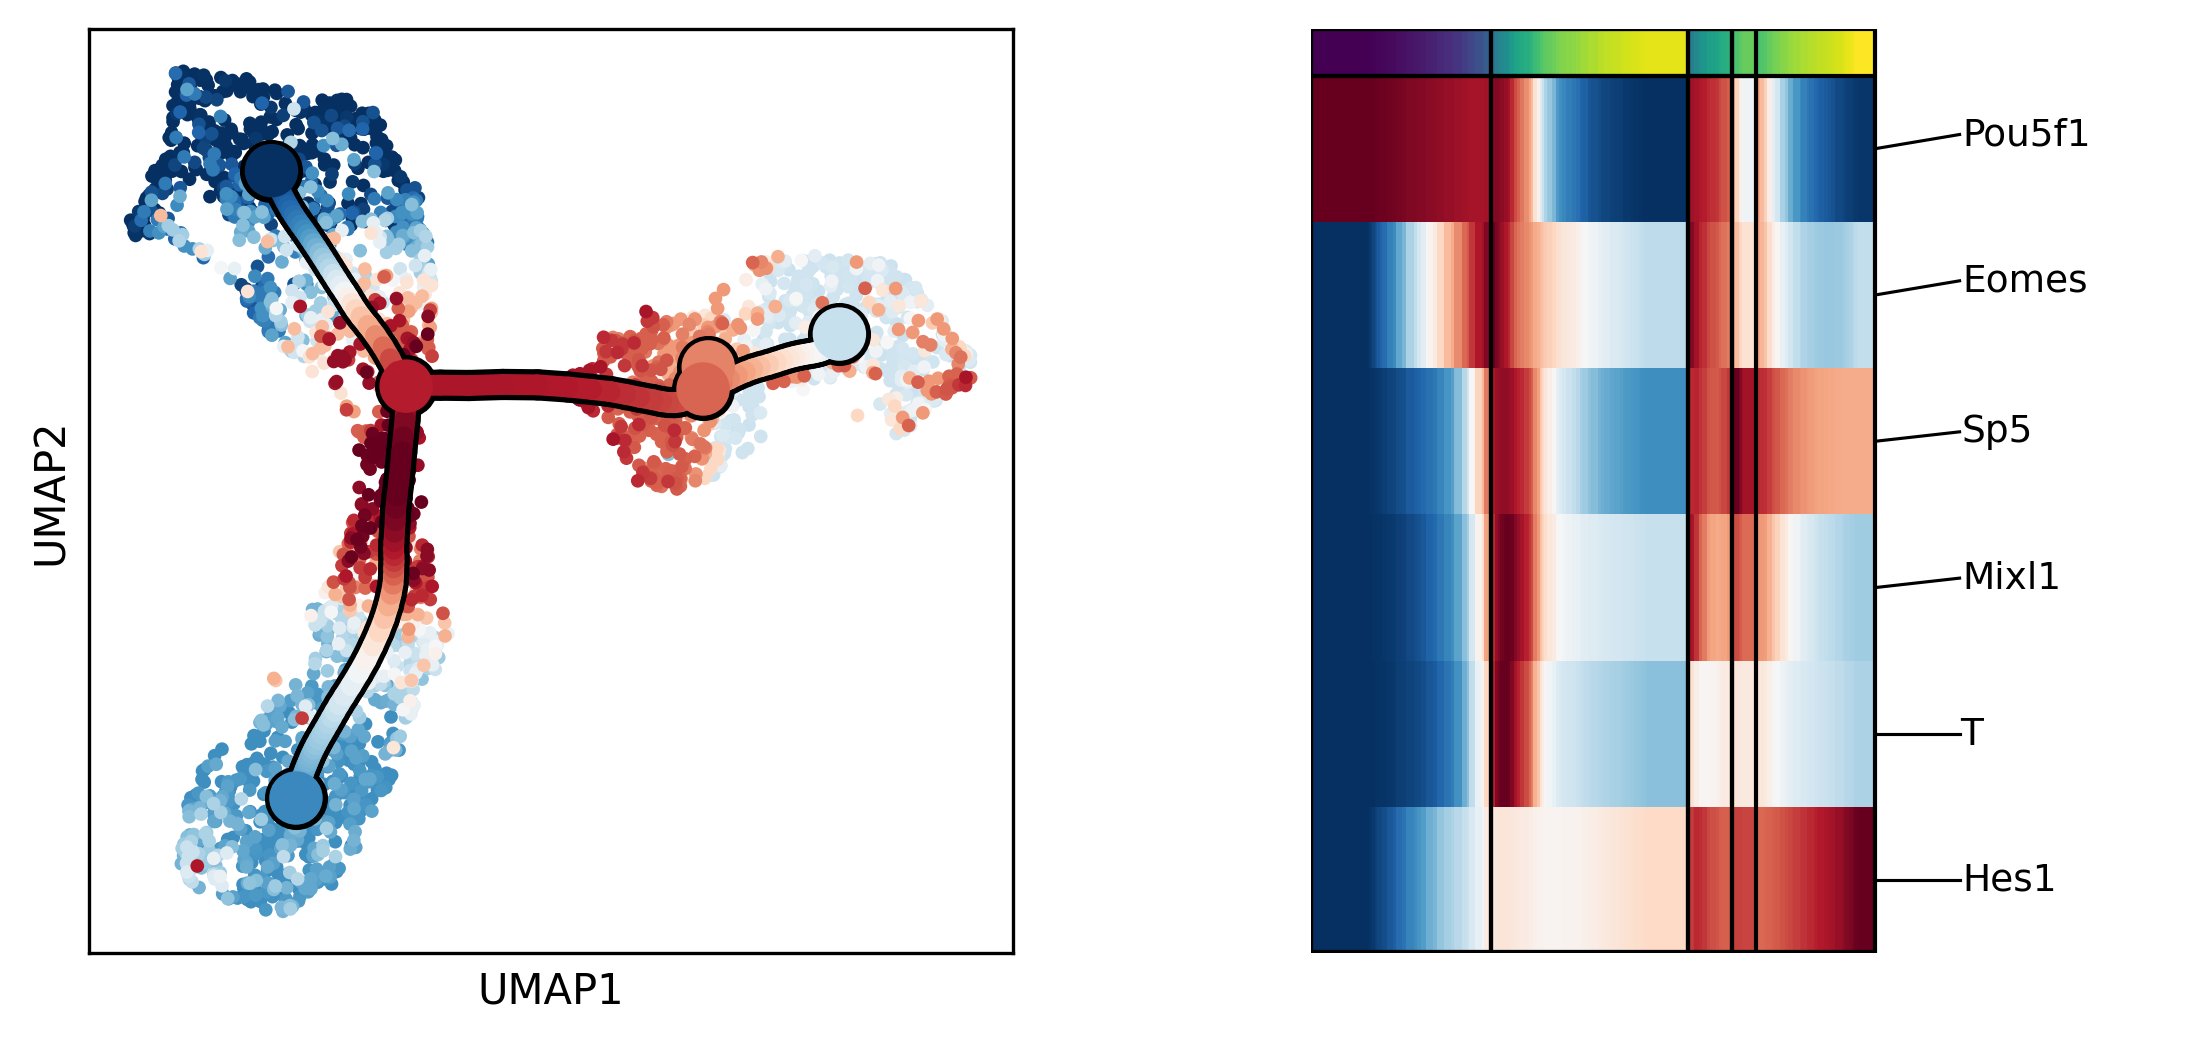

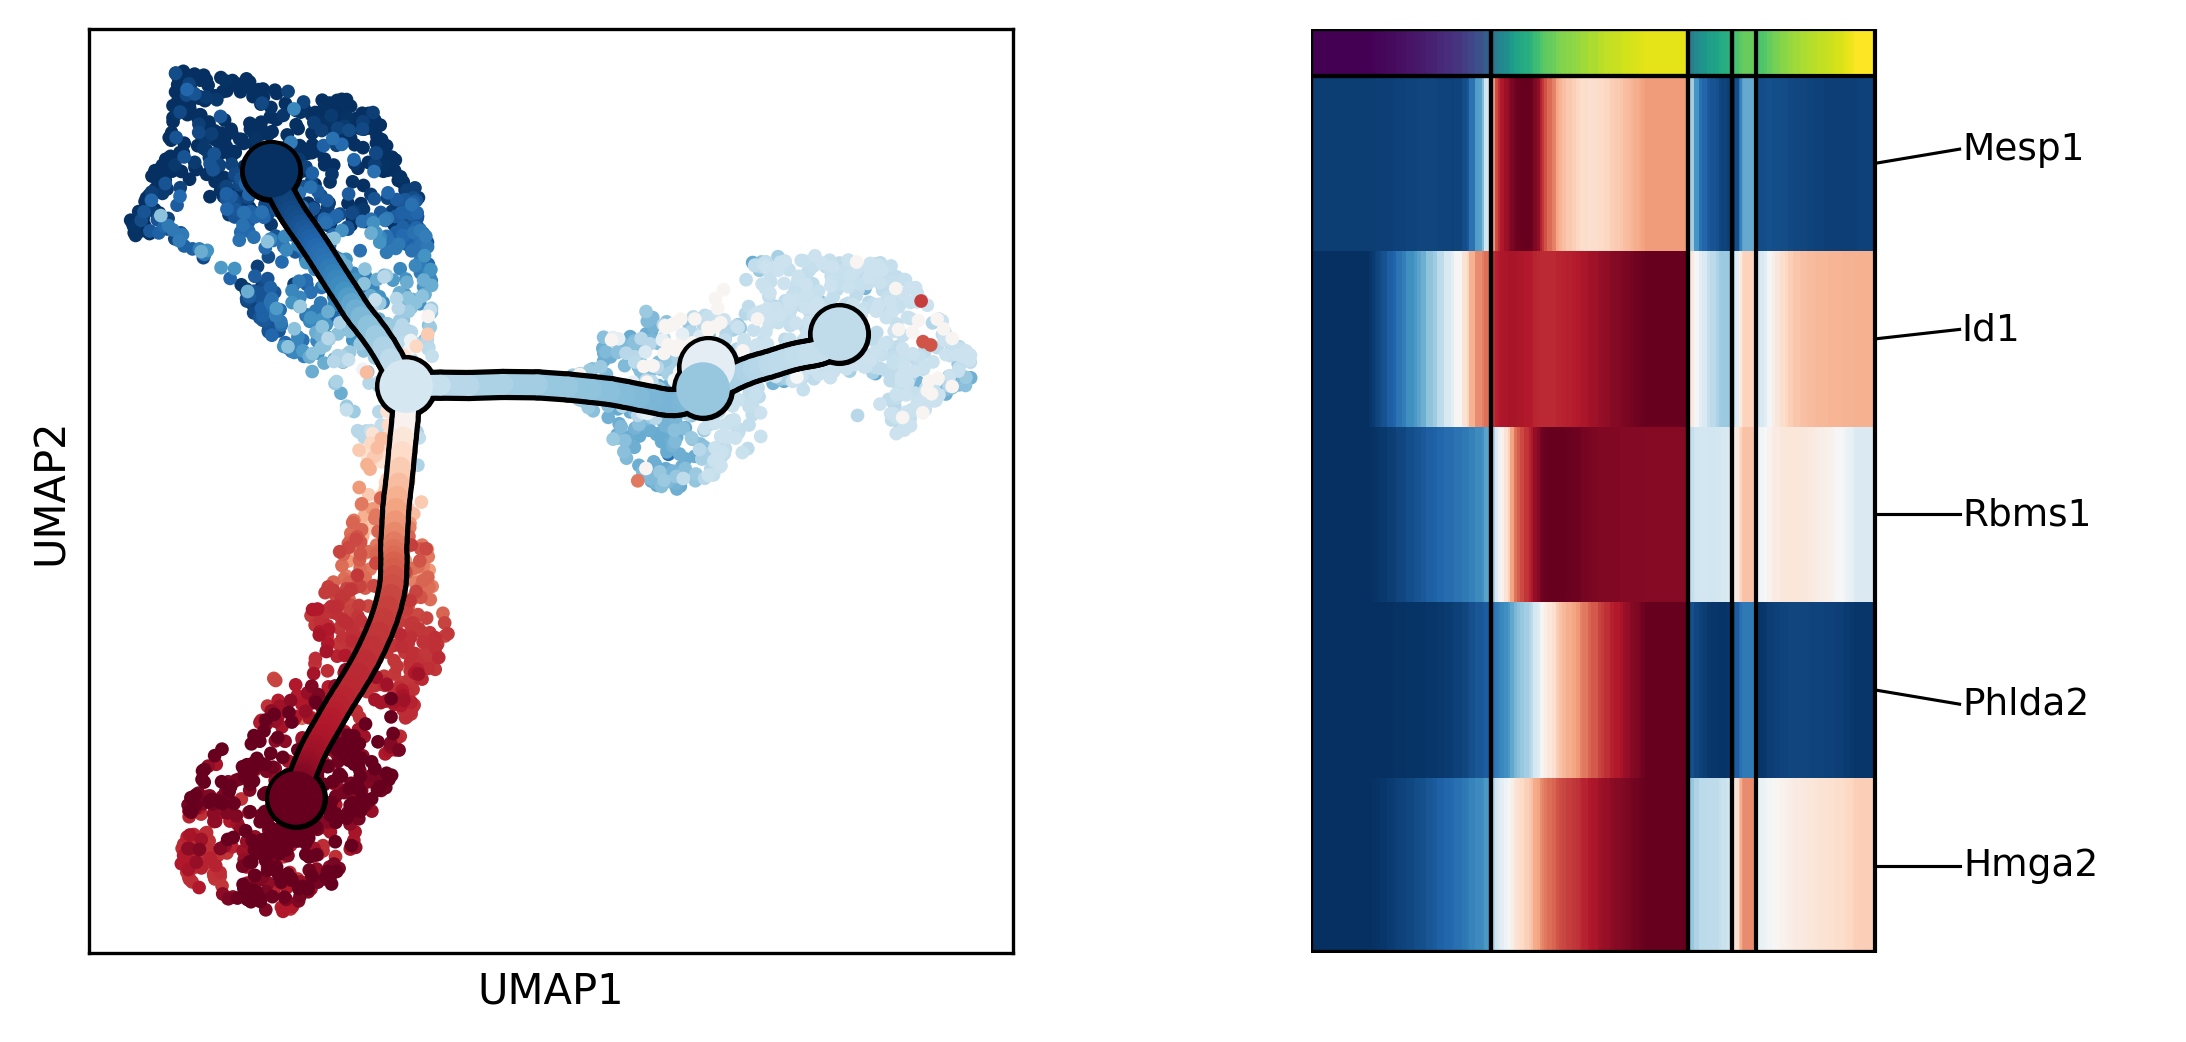

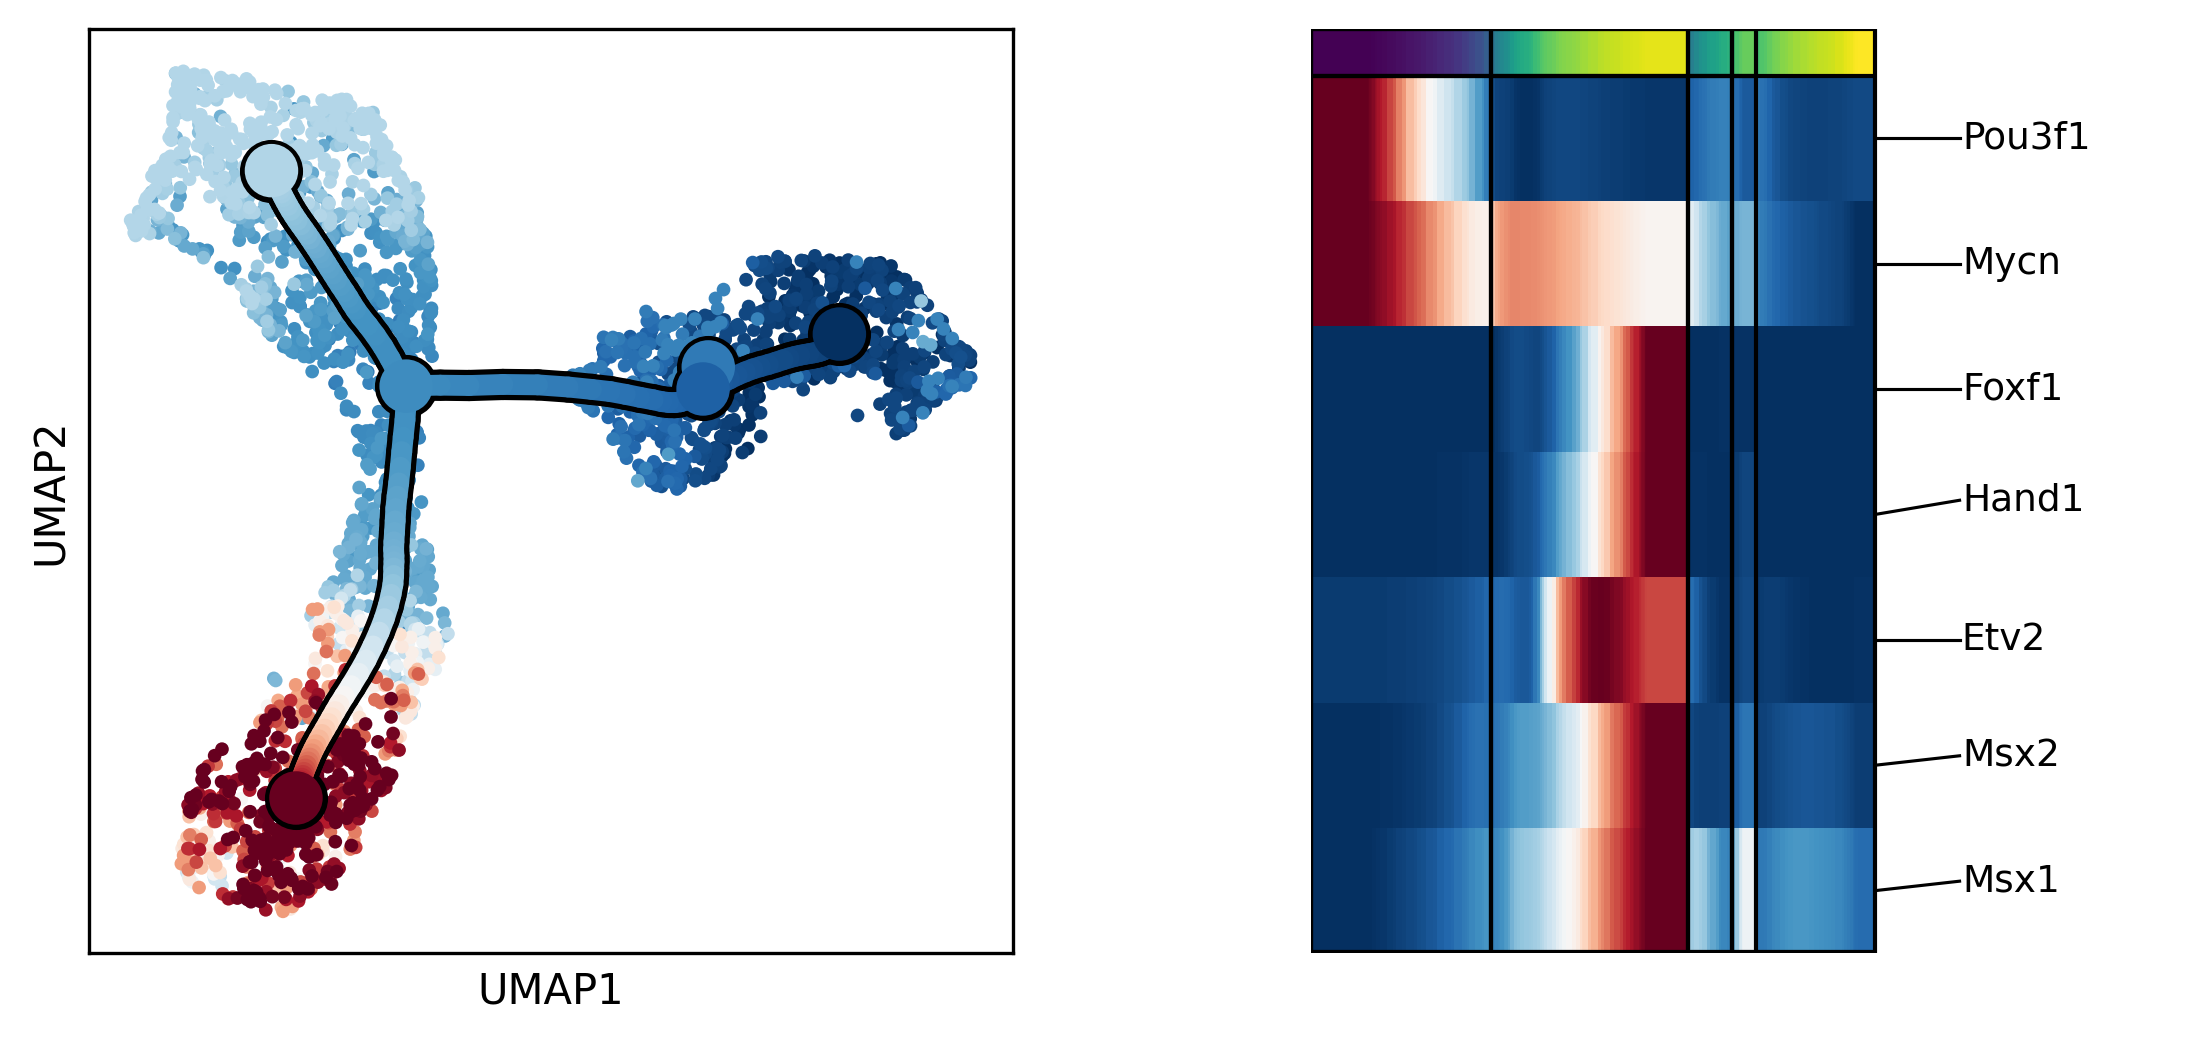

In [63]:
for c in adTF.var["clusters"].unique():
    scf.pl.trends(adTF,features=adTF.var_names[adTF.var.clusters==c],basis="umap")

| Cell Type |       Transcription Factors      | Factors For Investigation | 
| --------- | -------------------------------- | ------------------------- |
|  Epiblast | Pou5f1, Pou3f1, Mycn, Eomes, T   |    Pou5f1, Pou3f1, Mycn   |       
|  Mesoderm | Mesp1, Id1, Rbms1, Phlda2, Hmga2 |     Id1, Rbms1, Hmga2     | 
|    APS    | Foxa2, Gsc, Hhex, Sox17, Lhx1    |      Sox17, Gsc, Hhex     |

Each of the factors chosen for future investigation were selected due to showing the highest expression throughout their respective phases of pseudotime corresponding to the appropriate cell clusters with minimal expression in other phases of pseudotime. 